In [13]:
ALGORITHM = 'XG Boost'
ALGORITHM_DETAIL = 'random search'
VERSION = '09'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [14]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', XGBRegressor(seed=20))
])

In [15]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221025B import set_csv_directory, get_combined_dataset, get_columns
    from functions_20221025B import add_supplements, tidy_dataset, preprocess, feature_engineer

    set_csv_directory('final_split')

debug_mode = False

In [18]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [19]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    features = df[df.columns[2:]].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index



In [20]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v09.csv
(46871, 19)


In [21]:
df

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126179018,575000.0,2.0,1.0,0.682879,51.370651,-0.238346,0.129069,0.133926,FREEHOLD,0,0,0,0,0,0,0,0,0,0
126179672,600000.0,3.0,2.0,0.545665,51.357170,-0.074740,0.142550,0.029680,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
126180107,419999.0,2.0,1.0,0.191407,51.531415,-0.052964,0.031695,0.051456,LEASEHOLD,0,0,0,0,0,0,0,0,0,0
126180704,475000.0,2.0,1.0,0.308609,51.543141,0.011498,0.043421,0.115918,LEASEHOLD,0,0,0,0,0,0,0,0,0,0


In [22]:
df.isnull().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [23]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         46871 non-null  float64
 1   bedrooms                      46871 non-null  float64
 2   bathrooms                     46871 non-null  float64
 3   nearestStation                46871 non-null  float64
 4   location.latitude             46871 non-null  float64
 5   location.longitude            46871 non-null  float64
 6   latitude_deviation            46871 non-null  float64
 7   longitude_deviation           46871 non-null  float64
 8   tenure.tenureType             44127 non-null  object 
 9   feature__balcony              46871 non-null  int64  
 10  feature__chain free           46871 non-null  int64  
 11  feature__no onward chain      46871 non-null  int64  
 12  feature__off street parking   46871 non-null  int

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
count,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000
mean,425069.390775,1.992469,1.182074,0.438847,51.497049,-0.113269,0.064317,0.124202,0.038617,0.120266,0.057925,0.047300,0.041369,0.039662,0.047663,0.059120,0.071473,0.095411
std,107227.324906,0.828837,0.409879,0.325942,0.077085,0.156489,0.042573,0.095607,0.193124,0.325800,0.233604,0.212684,0.199144,0.195275,0.213354,0.235851,0.257616,0.293930
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227169,51.438861,-0.210796,0.028876,0.043560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425000.000000,2.000000,1.000000,0.367971,51.499977,-0.102230,0.058595,0.098984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515000.000000,3.000000,1.000000,0.559620,51.556183,-0.010343,0.094362,0.192684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600000.000000,7.000000,5.000000,7.197700,51.683185,0.279726,0.201403,0.393895,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000


In [24]:
old_length = len(df)
#df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
#df = df[(df['location.longitude'] <= 10)]
#df = df[(df['longitude_deviation'] <= 1)]

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [25]:
df.isna().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [26]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699,0.038865,0.121218,0.058898,0.047001,0.041834,0.040111,0.048428,0.059374,0.072586,0.096857
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220,0.193744,0.326940,0.235437,0.212071,0.200211,0.196338,0.214989,0.236326,0.259459,0.295919
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000


In [27]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [28]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [29]:
from time import time

#pipe.fit(X_train, y_train)

model = XGBRegressor()
#model.fit(X_train, y_train)
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [30]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

options_block = {
    'objective': 'reg:squarederror',
    'base_score': None,
    #'booster': ['gbtree', 'gblinear', 'dart'],
    'callbacks': None,
    #'colsample_bylevel': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bynode': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 1],
    'early_stopping_rounds': None,
    'enable_categorical': False,
    'eval_metric': None,
    #'gamma': [0,10,100,1000],
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    #'max_delta_step': [1,2,5,10,30],
    #'max_depth': [1,3,6,10,30],
    #'max_leaves': None,
    #'min_child_weight': [1,2,5,10,30],
    ###'missing': nan,
    #'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': [0,1,2,5,10,30],
    # 'reg_lambda': [1,2,5,10,30],
    # 'sampling_method': ['uniform','subsample','gradient_based'],
    # 'scale_pos_weight': [0.5,1,2],
    # 'subsample': [0.1, 0.3, 0.5, 0.7, 1],
    # 'tree_method': ['auto','approx','hist','gpu_hist','exact'],
    # 'validate_parameters': False,
    'verbosity': 1}

options_block = {
    'objective': 'reg:squarederror',
    # 'base_score': None,
    # 'booster': None,
    # 'callbacks': None,
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    # 'early_stopping_rounds': None,
    # 'enable_categorical': False,
    # 'eval_metric': None,
    # 'gamma': None,
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    # 'max_delta_step': None,
    # 'max_depth': None,
    'max_depth': [1, 3, 6, 10, 30],
    # 'max_leaves': None,
    # 'min_child_weight': None,
    ###'missing': nan,
    # 'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': None,
    # 'reg_lambda': None,
    # 'sampling_method': None,
    # 'scale_pos_weight': None,
    # 'subsample': None,
    # 'tree_method': None,
    #'tree_method': ['auto', 'approx', 'hist', 'gpu_hist', 'exact'],
    'tree_method': ['auto', 'approx', 'hist', 'exact'],
    # 'validate_parameters': None,
    'verbosity': 1}

param_grid = {}
for each in options_block:
    if type(options_block[each]) == list:
        param_grid['model__' + each] = options_block[each]
    elif options_block[each] == None:
        #print (f'skipping {each} because value is {options_block[each]}')
        param_grid['model__' + each] = [options_block[each]]
    else:
        param_grid['model__' + each] = [options_block[each]]
#param_grid

cv = 3
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

# temp override
cv = 2

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True, n_iter=30),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [31]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[4.27869987487793]
4.27869987487793


In [32]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__verbosity': 1, 'model__tree_method': 'approx', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 10}
0.506 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.505 (+/-0.007) for {'model__verbosity': 1, 'model__tree_method': 'approx', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.505 (+/-0.007) for {'model__verbosity': 1, 'model__tree_method': 'hist', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.506 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'exact', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.619 (+/-0.004) for {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 3}
0.624 

In [33]:
y_pred = pipe.predict(X_test)

In [34]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.7073963309687036
Mean Absolute Error Accuracy 43377.72424512803
Mean Squared Error Accuracy 3305369733.8557196
Root Mean Squared Error 57492.345002232425


In [35]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [36]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754.0,400000.0,372872.59375,27127.40625,6.781852,7.275248
119328242.0,369950.0,490971.25000,121021.25000,32.712867,24.649356
125716790.0,350000.0,315640.00000,34360.00000,9.817143,10.885819
122440040.0,549000.0,503441.96875,45558.03125,8.298366,9.049311
120508103.0,495000.0,520287.78125,25287.78125,5.108643,4.860345
...,...,...,...,...,...
68620869.0,475000.0,538112.87500,63112.87500,13.286921,11.728557
85735665.0,575000.0,486193.06250,88806.93750,15.444685,18.265776
125706338.0,400000.0,397817.62500,2182.37500,0.545594,0.548587


In [37]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [38]:
score = pipe.score(X_test, y_test)
score

0.7073963309687036

In [39]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.7073963309687036

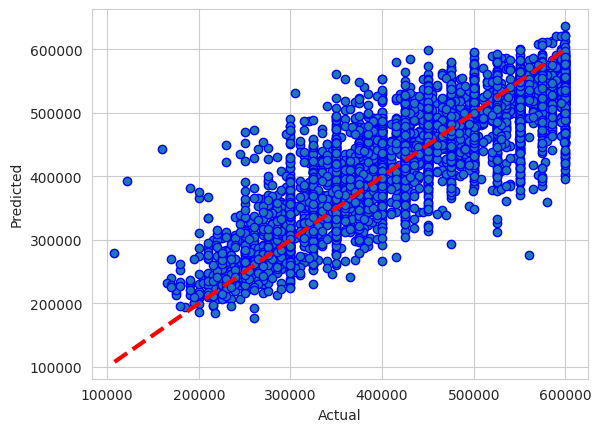

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [41]:
if False:
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            #return pd.Series({**params, **d})
            return pd.Series({**params, **d, **{'params_full': str(params)}})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


    import seaborn as sns

    score_summary = score_summary(self=gs, sort_by='max_score')

In [42]:

if False:
    #sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    #total_graphs = len(score_summary)
    # max_horizontal = 4
    # index2 = 0
    # resultant_rows = math.ceil(total_graphs / max_horizontal)
    # #subplots_adjust()
    #
    # #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    best_estimator = score_summary.iloc[0]
    worst_estimator = score_summary.iloc[-1]

    name_best = best_estimator["estimator"]
    params_str = best_estimator["params_full"]
    params_best = ast.literal_eval(params_str)

    name_worst = worst_estimator["estimator"]
    params_str = worst_estimator["params_full"]
    params_worst = ast.literal_eval(params_str)

    KNeighborsRegressor().set_params()

    best_pipe = make_pipe(name_best)
    worst_pipe = make_pipe(name_worst)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[0],
                    s=100).set(
        title=f'"BEST" model: {name_best} \n{params_best}')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[1],
                    s=100).set(
        title=f'"WORST" model: {name_worst} \n{params_worst}')

    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, color='orange')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')

    fig.tight_layout()
    plt.show()

if False:
    max_horizontal = 3

    #sns.set()
    #sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    total_graphs = len(score_summary)
    index2 = 0
    resultant_rows = math.ceil(total_graphs / max_horizontal)
    #subplots_adjust()

    #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    for (key, next_estimator), index in zip(score_summary.iterrows(), range(total_graphs)):
        if index % (max_horizontal * 2) == 0 and index != 0:
            index2 = 0
            fig.tight_layout()
            plt.show()
            #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
            fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

        name_next = next_estimator["estimator"]
        params_str = next_estimator["params_full"]
        params_next = ast.literal_eval(params_str)
        #print("next", params_next)

        if 'noscale' in name_next:
            pipe = Pipeline(steps=[
                ('preprocessor', features_noscale_preprocessor),  # preprocess features
                ('estimator', models_and_params[name_next]["model"]),
            ])  # start the training
        else:
            pipe = Pipeline(steps=[
                ('preprocessor', features_preprocessor),
                ('estimator', models_and_params[name_next]["model"]),  # preprocess features
            ])  # start the training

        # 0 ==> 0,0
        # 1 ==> 0,1
        # 2 ==> 1,0
        x_coor = index2 // max_horizontal
        y_coor = index2 % max_horizontal

        coordinates = axes[x_coor][y_coor]
        #sns.lineplot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], hue='red', lw=3)
        sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=coordinates, color='red')
        sns.scatterplot(x=y_test, y=pipe.set_params(**params_next).fit(X_train, y_train).predict(X_test),
                        ax=coordinates, s=100).set(
            title=f'({index}) {"BEST" if index == 0 else "next"} model: {name_next} \n{params_next}')
        #if index == 11: break
        index2 += 1

    fig.tight_layout()
    plt.show()

In [43]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['Score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['max params'] = new_results['params']
        new_results['max score'] = new_results['Score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['Score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4, sort_keys=True))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.7073963309687036,
 'R square Accuracy': 0.7073963309687036,
 'Mean Absolute Error Accuracy': 43377.72424512803,
 'Mean Squared Error Accuracy': 3305369733.8557196,
 'Root Mean Squared Error': 57492.345002232425,
 'Training Time': 4.27869987487793,
 'random_state': 101,
 'date': '2022-10-25 20:12:31.575473',
 'params': {'model__verbosity': 1,
  'model__tree_method': 'approx',
  'model__objective': 'reg:squarederror',
  'model__n_estimators': 100,
  'model__max_depth': 10},
 'first run': '2022-10-25 20:12:31.576998',
 'max params': {'model__verbosity': 1,
  'model__tree_method': 'approx',
  'model__objective': 'reg:squarederror',
  'model__n_estimators': 100,
  'model__max_depth': 10},
 'max score': 0.7073963309687036,
 'suboptimal': 'pending'}

In [44]:
results
import pickle

# try:
#     model = pickle.load(open(f'model_{ALGORITHM}.pkl', 'rb'))
#     # raise ValueError
# except:
#     model = build_model(ALGORITHM, drop_nulls=~include_nulls)
#     with open(f'models/model_{ALGORITHM}.pkl', 'wb') as f:
#         pickle.dump(model, f)


with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}.pkl', 'wb') as f:
    pickle.dump(grid_result.best_estimator_, f)